<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models</h4>
    <p style="font-size: 20px;">NBA API Data (1984-2024)</p>
</div>

<a name="Baseline Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

- [Description](#Description)

- [Filter Time-Span](#Filter-Time-Span)

- [Scale Data](#Scale-Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

In [2]:
# get team matchups with box score rolling averages
team_bs_matchups_roll_df = pd.read_csv('../data/processed/nba_team_matchups_rolling_stats_1984_2024_r20.csv')

# convert 'GAME_DATE' column to datetime
team_bs_matchups_roll_df['GAME_DATE'] = pd.to_datetime(team_bs_matchups_roll_df['GAME_DATE'])

## Description

[Return to top](#Baseline-Models)

In [3]:
team_bs_matchups_roll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52101 entries, 0 to 52100
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SEASON_ID               52101 non-null  int64         
 1   HOME_TEAM_ID            52101 non-null  int64         
 2   HOME_TEAM_ABBREVIATION  52101 non-null  object        
 3   HOME_TEAM_NAME          52101 non-null  object        
 4   GAME_ID                 52101 non-null  int64         
 5   GAME_DATE               52101 non-null  datetime64[ns]
 6   HOME_WL                 52098 non-null  object        
 7   HOME_MIN                52101 non-null  int64         
 8   HOME_PTS                52101 non-null  int64         
 9   HOME_FGM                52101 non-null  int64         
 10  HOME_FGA                52101 non-null  int64         
 11  HOME_FG_PCT             52101 non-null  float64       
 12  HOME_FG3M               52101 non-null  int64 

In [4]:
team_bs_matchups_roll_df.head()

,SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,GAME_ID,GAME_DATE,HOME_WL,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,...,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS
0,21983,1610612737,ATL,Atlanta Hawks,28300014,1983-10-29,W,240,117,49,94,0.521,0,1.0,0.0,19,30,0.633,27.0,21.0,48.0,28,14.0,7,23,...,NaN,NaN,NaN,NaN,NaN,240.300,112.150,43.100,89.5,0.483,10.850,29.650,0.368,15.100,20.550,0.723,12.100,32.050,44.150,27.800,6.850,5.650,11.2,18.600,-0.3
1,21983,1610612737,ATL,Atlanta Hawks,28300027,1983-11-01,W,240,95,38,81,0.469,0,0.0,NaN,19,30,0.633,12.0,29.0,41.0,20,7.0,10,16,...,14.000,7.0,23.00,35.0,NaN,240.000,105.500,39.000,81.5,0.478,0.000,2.000,0.000,27.500,35.000,0.782,12.500,30.500,43.000,26.500,8.500,3.000,22.0,33.500,NaN
2,21983,1610612737,ATL,Atlanta Hawks,28300041,1983-11-04,W,240,103,42,86,0.488,1,1.0,1.0,18,26,0.692,19.0,27.0,46.0,31,14.0,13,18,...,10.500,8.5,19.50,34.5,NaN,240.000,99.000,37.000,99.5,0.373,1.500,4.500,0.375,23.500,31.000,0.754,20.000,27.000,47.000,18.500,10.500,6.500,18.5,30.500,NaN
3,21983,1610612737,ATL,Atlanta Hawks,28300101,1983-11-15,W,240,107,45,84,0.536,0,0.0,NaN,17,21,0.810,17.0,24.0,41.0,24,7.0,10,18,...,11.667,10.0,19.00,32.0,NaN,246.167,110.167,44.667,91.5,0.489,0.667,1.833,0.400,20.167,28.833,0.701,14.333,26.833,41.167,24.167,9.667,4.333,17.0,27.333,NaN
4,21983,1610612737,ATL,Atlanta Hawks,28300112,1983-11-17,W,240,99,35,66,0.530,1,2.0,0.5,28,40,0.700,10.0,35.0,45.0,20,5.0,12,23,...,10.500,10.0,18.75,30.5,NaN,248.333,119.667,44.667,88.0,0.508,0.667,1.000,0.750,29.667,40.000,0.742,16.000,27.667,43.667,26.667,11.667,6.667,20.0,25.667,NaN


In [5]:
team_bs_matchups_roll_df.describe()

,SEASON_ID,HOME_TEAM_ID,GAME_ID,GAME_DATE,HOME_MIN,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PLUS_MINUS,AWAY_TEAM_ID,...,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_HOME_PLUS_MINUS,ROLL_AWAY_MIN,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,ROLL_AWAY_PLUS_MINUS
count,52101.000,5.210e+04,5.210e+04,52101,52101.000,52101.000,52101.000,52101.000,52101.000,52101.00,52100.000,51484.000,52101.000,52101.000,52099.000,52098.000,52098.000,52101.000,52101.000,52100.000,52101.000,52101.000,52101.000,37261.000,5.210e+04,...,52100.000,52100.000,52100.000,52100.000,37592.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52095.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,52100.000,37593.000
mean,22881.387,1.611e+09,5.805e+07,2005-02-11 14:31:23.434099200,240.466,103.698,38.866,83.498,0.466,6.29,17.681,0.343,19.676,25.997,0.757,12.095,31.263,43.359,23.642,7.979,5.301,14.395,21.615,2.819,1.611e+09,...,7.991,5.304,14.426,21.656,2.810,240.438,100.358,37.756,83.308,0.454,6.111,17.560,0.333,18.734,24.839,0.755,11.704,30.090,41.797,21.897,7.847,4.683,14.830,22.440,-2.823
min,12003.000,1.611e+09,1.030e+07,1983-10-28 00:00:00,-1.000,0.000,0.000,1.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-68.000,1.611e+09,...,3.000,1.000,8.750,14.750,-29.000,60.000,61.000,24.000,65.750,0.337,0.000,0.000,0.000,10.900,13.000,0.571,6.000,18.000,28.000,5.000,4.000,1.000,7.000,14.750,-29.000
25%,21994.000,1.611e+09,2.090e+07,1995-04-02 00:00:00,240.000,94.000,35.000,78.000,0.425,3.00,10.000,0.256,15.000,20.000,0.696,9.000,27.000,39.000,20.000,6.000,3.000,11.000,18.000,-7.000,1.611e+09,...,7.100,4.450,13.250,20.050,-0.670,240.000,94.750,35.350,79.700,0.439,3.500,10.600,0.316,16.850,22.400,0.733,10.250,28.200,40.100,19.950,7.100,4.050,13.500,20.700,-6.050
50%,22005.000,1.611e+09,2.200e+07,2005-12-28 00:00:00,240.000,103.000,39.000,83.000,0.465,6.00,16.000,0.345,19.000,25.000,0.763,12.000,31.000,43.000,23.000,8.000,5.000,14.000,21.000,4.000,1.611e+09,...,7.900,5.150,14.300,21.500,3.050,241.200,99.650,37.450,83.150,0.453,5.750,16.500,0.342,18.500,24.650,0.756,11.550,29.850,41.750,21.700,7.750,4.650,14.650,22.250,-2.750
75%,22015.000,1.611e+09,2.920e+07,2015-01-02 00:00:00,240.000,113.000,43.000,89.000,0.506,9.00,24.000,0.429,24.000,31.000,0.825,15.000,35.000,48.000,27.000,10.000,7.000,17.000,25.000,11.000,1.611e+09,...,8.750,6.000,15.500,23.100,6.500,242.500,105.650,40.050,86.650,0.468,8.300,23.400,0.364,20.400,27.050,0.779,13.000,31.800,43.350,23.700,8.600,5.250,15.950,24.050,0.500
max,62023.000,1.611e+09,1.622e+09,2024-01-21 00:00:00,688.000,184.000,68.000,135.000,0.833,28.00,70.000,2.000,61.000,80.000,1.000,37.000,55.000,77.000,50.000,27.000,23.000,39.000,45.000,73.000,1.611e+09,...,18.000,15.500,26.000,37.000,29.000,265.000,129.500,50.450,111.500,0.563,17.850,49.900,1.000,51.000,53.000,1.000,26.500,43.350,57.000,33.500,14.000,10.000,29.000,38.000,29.000
std,5186.768,8.567e+00,2.191e+08,NaN,12.120,14.052,6.116,8.783,0.059,4.47,10.747,0.156,6.795,8.419,0.099,4.433,5.656,6.879,5.736,3.099,2.759,4.152,4.730,13.416,8.571e+00,...,1.238,1.263,1.719,2.246,5.281,3.773,7.556,3.185,4.843,0.022,3.524,9.593,0.051,2.621,3.377,0.035,1.997,2.644,2.457,2.653,1.110,0.915,1.895,2.485,4.832


## Filter Time-Span

[Return to top](#Baseline-Models)

In [6]:
# filter data to time span of interest
baseline_df = team_bs_matchups_roll_df[team_bs_matchups_roll_df['GAME_DATE'] >= '2019-09-01']

## Scale Data

[Return to top](#Baseline-Models)

In [7]:
# feature columns
feature_names = [col for col in baseline_df.columns if col.startswith('ROLL_')] 
features = baseline_df[feature_names]

# target columns
target_pts = baseline_df['TOTAL_PTS'] 
target_pm  = baseline_df['PLUS_MINUS']
target_res = baseline_df['GAME_RESULT']

# scale data (default is min_max and unscaled target)
baseline_pts_scaled = utl.scale_data(features, target_pts, scaler='minmax', scale_target=False)
baseline_pm_scaled = utl.scale_data(features, target_pm, scaler='minmax', scale_target=False)
baseline_res_scaled = utl.scale_data(features, target_res, scaler='minmax', scale_target=False)

# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(baseline_pts_scaled, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [9]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(baseline_pts_scaled, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [10]:
# configuration for total points with expanding window

initial_train_size = 500 # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
df = baseline_pts_scaled # data set to use
target_col = 'TOTAL_PTS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 33.15 seconds


In [11]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 21.77


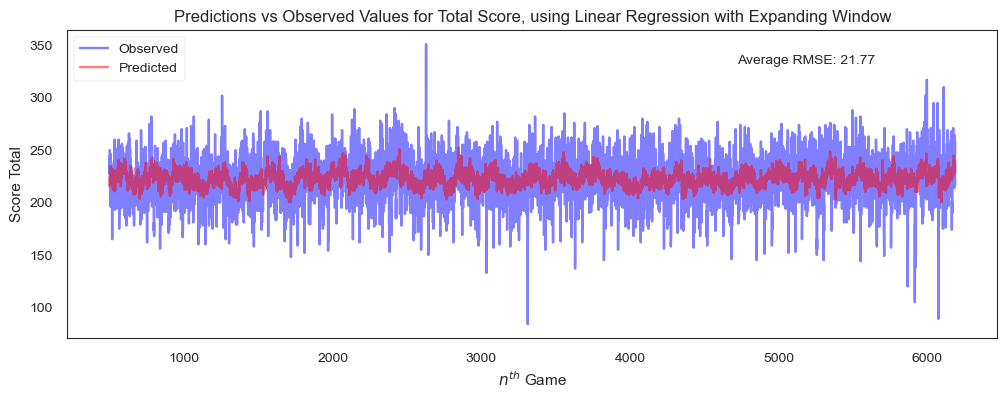

In [12]:
# observed values
observed_values = df[target_col][initial_train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [13]:
# configuration for total points with rolling window

train_size = 500         # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
df = baseline_pts_scaled # data set to use
target_col = 'TOTAL_PTS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 18.85 seconds


In [14]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 22.94


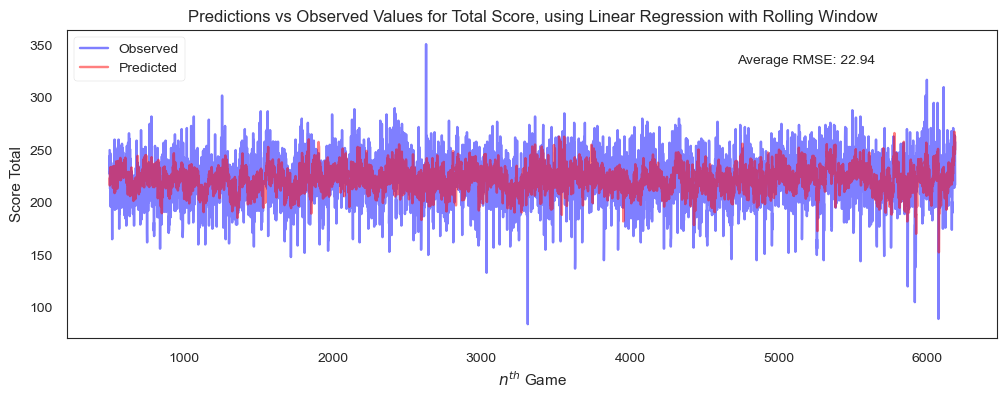

In [15]:
# observed values
observed_values = df[target_col][train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

### Experiments with different window sizes

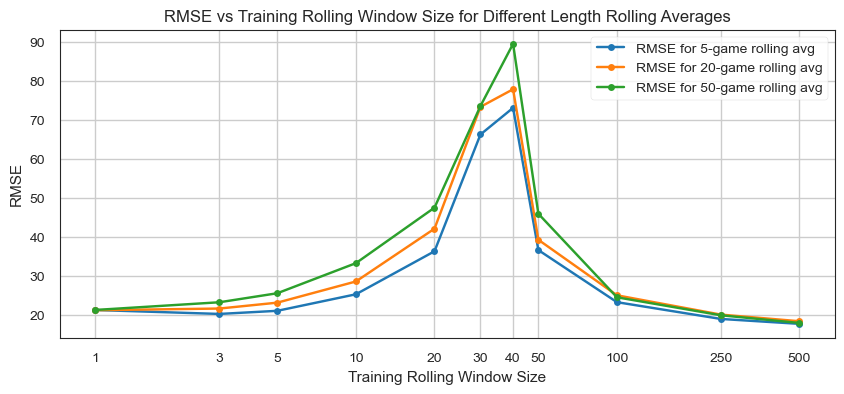

In [16]:
# Experiments with different window sizes

data = {
    "Window Size": [1, 3, 5, 10, 20, 30, 40, 50, 100, 250, 500],
    "RMSE_5_games": [21.36, 20.35, 21.15, 25.38, 36.39, 66.28, 73.10, 36.69, 23.36, 19.07, 17.81],
    "RMSE_20_games": [21.3, 21.73, 23.24, 28.66, 42.17, 73.36, 77.86, 39.33, 25.12, 20.18, 18.48],
    "RMSE_50_games": [21.36, 23.34, 25.65, 33.35, 47.55, 73.57, 89.48, 45.99, 24.61, 20.01, 18.04]
}
rmse_df = pd.DataFrame(data)

plt.figure(figsize=(10, 4))
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_5_games'], label='RMSE for 5-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_20_games'], label='RMSE for 20-game rolling avg', marker='o', markersize=5)
plt.plot(rmse_df['Window Size'], rmse_df['RMSE_50_games'], label='RMSE for 50-game rolling avg', marker='o', markersize=5)
plt.title('RMSE vs Training Rolling Window Size for Different Length Rolling Averages')
plt.xlabel('Training Rolling Window Size')
plt.ylabel('RMSE')
#plt.xticks(rmse_df['Window Size'])
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rmse_df['Window Size'], labels=rmse_df['Window Size'].astype(str))
plt.grid(True)
plt.legend()
plt.show()

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [17]:
# configuration for points difference with expanding window

initial_train_size = 500  # starting size of the training set
test_size = 1             # leave-one-out (LOO) cross-validation
df = baseline_pm_scaled   # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 33.62 seconds


In [18]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 14.33


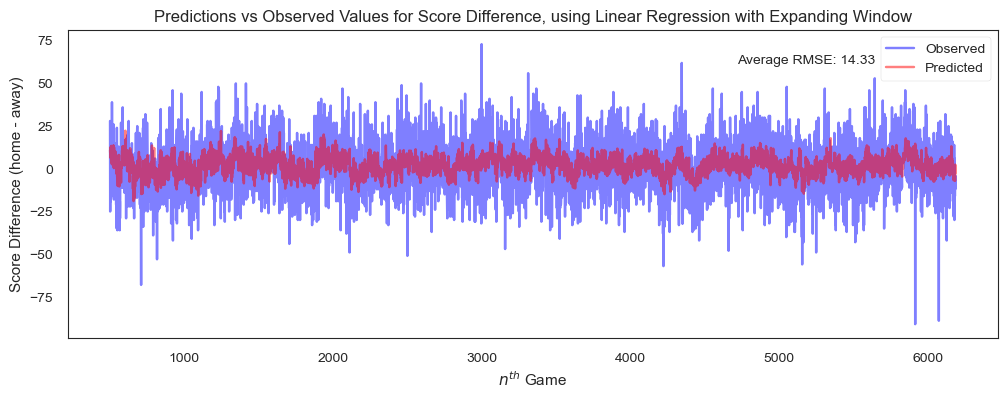

In [19]:
# observed values
observed_values = df[target_col][initial_train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [20]:
# configuration for points difference with rolling window

train_size = 500          # starting size of the training set
test_size = 1             # leave-one-out (LOO) cross-validation
df = baseline_pm_scaled   # data set to use
target_col = 'PLUS_MINUS' # target column name

# run model
model_outputs_lin, y_true_lin = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LinearRegression() 
)

Total time taken: 20.40 seconds


In [21]:
reg_metrics_lin = utl.calculate_metrics(y_true_lin, model_outputs_lin, model_type='linear')

Linear Regression Metrics:
- Average RMSE: 15.19


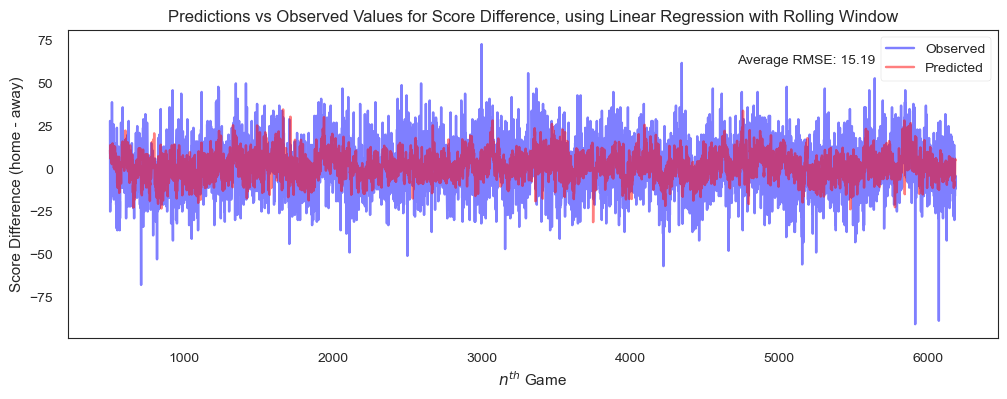

In [22]:
# observed values
observed_values = df[target_col][train_size:]
# ensure that 'predictions' and 'observed_values' have the same length
predictions_aligned = model_outputs_lin[:len(observed_values)]

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, predictions_aligned, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Linear Regression with Rolling Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {reg_metrics_lin['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [23]:
# configuration for game winner with expanding window

initial_train_size = 500   # starting size of the training set
test_size = 1              # leave-one-out (LOO) cross-validation
df = baseline_res_scaled   # data set to use
target_col = 'GAME_RESULT' # target column name

# run model
model_outputs_log, y_true_log = utl.train_with_expanding_window(
    df=df, 
    initial_train_size=initial_train_size, 
    test_size=test_size, 
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True # ensure class diversity in training for logistic regression
)  

Total time taken: 54.18 seconds


In [24]:
reg_metrics_log = utl.calculate_metrics(y_true_log, model_outputs_log, model_type='logistic')

Logistic Regression Metrics:
- Average Accuracy: 0.60
- Overall AUC: 0.64
- Average F1 Score: 0.67


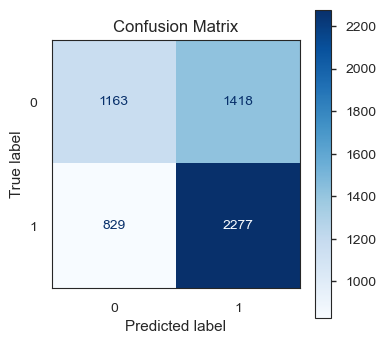

In [25]:
# calculate confusion matrix
cm = confusion_matrix(y_true_log, reg_metrics_log['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

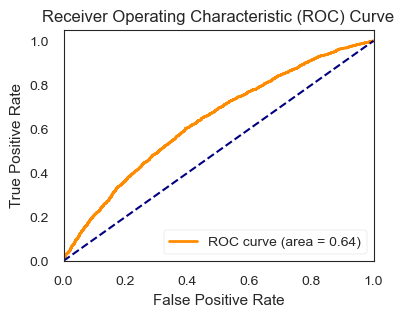

In [26]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true_log, reg_metrics_log['prob_predictions'])

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [27]:
# configuration for game winner with rolling window

train_size = 500           # starting size of the training set
test_size = 1              # leave-one-out (LOO) cross-validation
df = baseline_res_scaled   # data set to use
target_col = 'GAME_RESULT' # target column name

# run model
model_outputs_log, y_true_log = utl.train_with_rolling_window(
    df=df,  
    train_size=train_size, 
    test_size=test_size,           
    target_col=target_col, 
    model=LogisticRegression(max_iter=1000, solver='liblinear'),
    ensure_diversity=True
)

Total time taken: 12.37 seconds


In [28]:
reg_metrics_log = utl.calculate_metrics(y_true_log, model_outputs_log, model_type='logistic')

Logistic Regression Metrics:
- Average Accuracy: 0.59
- Overall AUC: 0.62
- Average F1 Score: 0.65


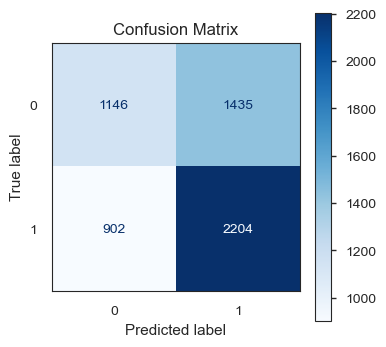

In [29]:
# calculate confusion matrix
cm = confusion_matrix(y_true_log, reg_metrics_log['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

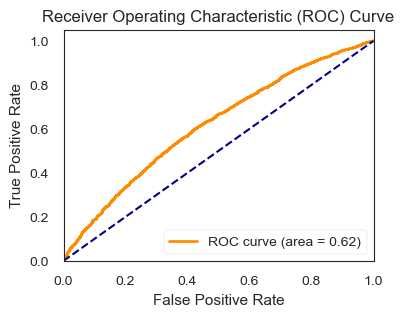

In [30]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true_log, reg_metrics_log['prob_predictions'])

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");